In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import nltk
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import codecs
from tqdm import tqdm
import shutil




from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from keras.callbacks import EarlyStopping

import re
from tensorflow.keras.preprocessing.text import one_hot
import warnings
warnings.filterwarnings("ignore")

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
train_cleaned_data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/train_cleaned_rnn.csv")
test_cleaned_data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/test_cleaned_rnn.csv")

X_train_data = train_cleaned_data['tweet_cleaned']
y_train_data = train_cleaned_data['label']

X_test_data = test_cleaned_data['tweet_cleaned']
y_test_data = test_cleaned_data['label']


### Textvorverarbeitung

In [20]:
def one_hot_enc(X_data, y_data):
  corpus = [str(text) for text in X_data]
  vocab_size = 5000

  #one hot encoding
  one_hot_dir = [one_hot(words,vocab_size) for words in corpus]

  embedded_layer = pad_sequences(one_hot_dir,padding = 'pre')
  return np.array(embedded_layer), np.array(y_data)

In [21]:
def tokenize(X_data, y_data, tokenizer=None, max_len=40):
    X_data = [str(x) for x in X_data]

    # # Wenn kein Tokenizer bereitgestellt wird, erstelle einen neuen
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=None, oov_token="<OOV>")
        tokenizer.fit_on_texts(X_data)

    # # Tokenisierung
    X_data_sequences = tokenizer.texts_to_sequences(X_data)

    X_data_padded_sequences = pad_sequences(X_data_sequences, padding='post', maxlen=max_len)
    return X_data_padded_sequences, y_data, tokenizer


### Sampling

In [22]:
def random_over_sample(X_data, y_data):
  ros = RandomOverSampler(random_state=42)
  X = X_data.values.reshape(-1, 1)
  y = y_data.values

  X_resampled, y_resampled = ros.fit_resample(X, y)
  X_resampled = X_resampled[:, 0]
  return X_resampled, y_resampled


### Embeddings

In [47]:
def load_embeddings(file_path, embedding_dim, word_index):
    embedding_index = {}
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            values = line.rstrip().split(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
import requests, zipfile, io
zip_file_url = "http://nlp.stanford.edu/data/glove.6B.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
import requests, zipfile, io
zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

### Model

In [45]:
def train_gru(x_train, y_train, x_val, y_val, vocab_size, max_len, embedding_matrix=None, embedding_dim=200, epochs=20, batch_size=32):
    model = Sequential()
    if embedding_matrix is not None:
        model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
    else:
        model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    model.add(SpatialDropout1D(0.35))
    model.add(GRU(256))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy', 'Recall'])


    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))
    return model, history


### Evaluation

In [26]:
def evaluate_on_val(model, history, X_val, y_val, threshold=0.35):
    """
    Evaluates the model on validation data with detailed metrics and visualizes training performance.

    Parameters:
    - model: Trained model to evaluate.
    - history: Training history object.
    - X_val: Validation data (features).
    - y_val: Validation data (labels).
    - threshold: Decision threshold to classify an instance as positive.

    Returns:
    None
    """
    # Plot Training and Validation Metrics
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate Validation Data
    print("\nValidation Performance:")
    y_val_pred = (model.predict(X_val) > threshold).astype(int)

    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_val, y_val_pred))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Hate Speech', 'Hate Speech'], yticklabels=['No Hate Speech', 'Hate Speech'])
    plt.title('Confusion Matrix - Validation Data')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


In [27]:
def evaluate_on_test(model, X_test, y_test, threshold=0.35):
    """
    Evaluates the model on an independent test dataset with detailed metrics.

    Parameters:
    - model: Trained model to evaluate.
    - X_test: Test data (features).
    - y_test: Test data (labels).
    - threshold: Decision threshold to classify an instance as positive.

    Returns:
    None
    """
    print("\nTest Performance:")
    y_test_pred = (model.predict(X_test) > threshold).astype(int)

    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['No Hate Speech', 'Hate Speech'], yticklabels=['No Hate Speech', 'Hate Speech'])
    plt.title('Confusion Matrix - Test Data')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


### Training/Evaluate

In [28]:
def one_hot_and_split_data(X_train_data, y_train_data, X_test_data, y_test_data):
  X_gru, y_gru = one_hot_enc(X_train_data, y_train_data)
  X_train_gru,X_val_gru,y_train_gru,y_val_gru=train_test_split(X_gru,y_gru,test_size=0.2,random_state=0)
  X_test_gru, y_test_gru = one_hot_enc(X_test_data, y_test_data)
  return X_train_gru, X_val_gru, y_train_gru, y_val_gru, X_test_gru, y_test_gru

In [29]:
def tokenize_and_split_data(X_train_data, y_train_data, X_test_data, y_test_data):
  X_gru, y_gru, tokenizer = tokenize(X_resampled, y_resampled)
  X_train_gru,X_val_gru,y_train_gru,y_val_gru=train_test_split(X_gru,y_gru,test_size=0.2,random_state=42)
  X_test_gru, y_test_gru, _= tokenize(X_test_data, y_test_data, tokenizer)
  return X_train_gru, X_val_gru, y_train_gru, y_val_gru, X_test_gru, y_test_gru, tokenizer

##### One-Hot

Epoch 1/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - Recall: 0.0350 - accuracy: 0.9275 - loss: 0.2514 - val_Recall: 0.4144 - val_accuracy: 0.9478 - val_loss: 0.1523
Epoch 2/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - Recall: 0.5470 - accuracy: 0.9612 - loss: 0.1063 - val_Recall: 0.3764 - val_accuracy: 0.9470 - val_loss: 0.1616
Epoch 3/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - Recall: 0.7646 - accuracy: 0.9805 - loss: 0.0567 - val_Recall: 0.4030 - val_accuracy: 0.9428 - val_loss: 0.1924
Epoch 4/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - Recall: 0.8895 - accuracy: 0.9883 - loss: 0.0344 - val_Recall: 0.3840 - val_accuracy: 0.9374 - val_loss: 0.2170
Epoch 5/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - Recall: 0.9358 - accuracy: 0.9937 - loss: 0.0202 - val_Recall: 0.3574 - val_accuracy: 0.9364 - val_loss: 0.2934
Epoch 6/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - Recall: 0.9821 - accuracy: 0.9972 - loss: 0.0096 - val_Recall: 0.3650 - val_accuracy: 0.9372 - val_loss:

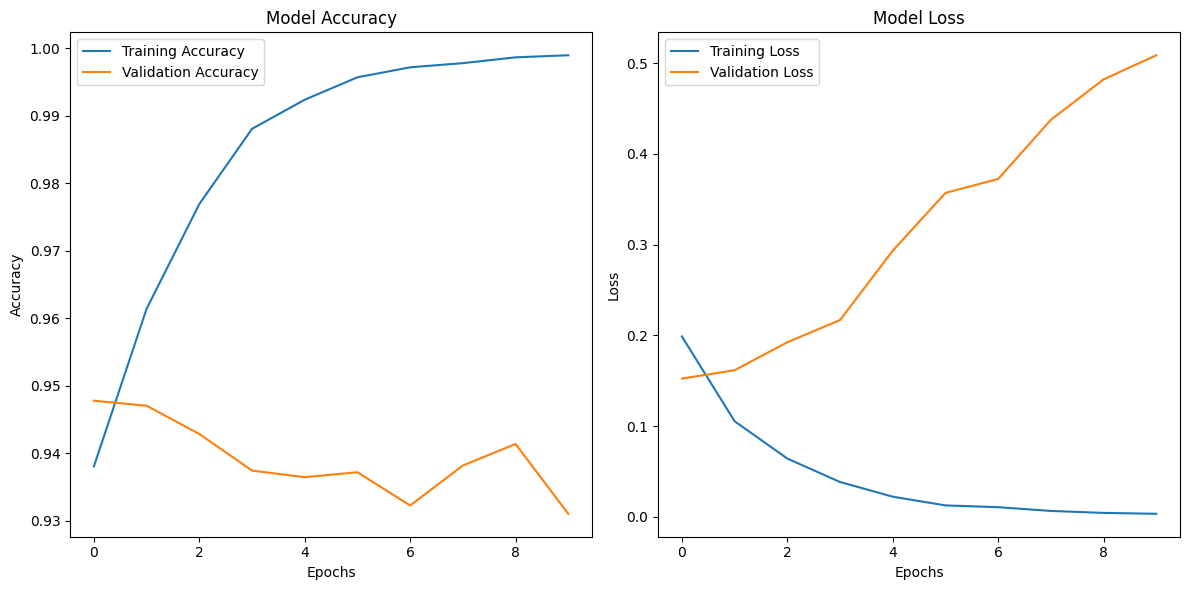


Validation Performance:
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy: 0.9303
Precision: 0.4597
Recall: 0.4335
F1 Score: 0.4462

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3795
           1       0.46      0.43      0.45       263

    accuracy                           0.93      4058
   macro avg       0.71      0.70      0.70      4058
weighted avg       0.93      0.93      0.93      4058



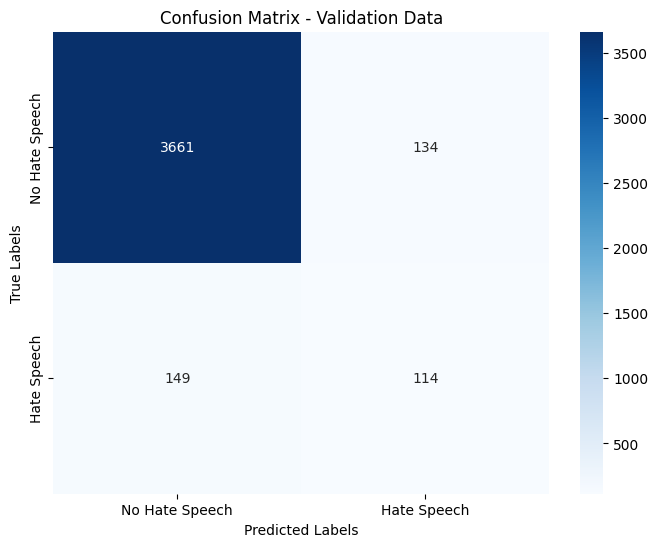


Test Performance:
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Accuracy: 0.9363
Precision: 0.5431
Recall: 0.4640
F1 Score: 0.5004

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      8468
           1       0.54      0.46      0.50       625

    accuracy                           0.94      9093
   macro avg       0.75      0.72      0.73      9093
weighted avg       0.93      0.94      0.93      9093



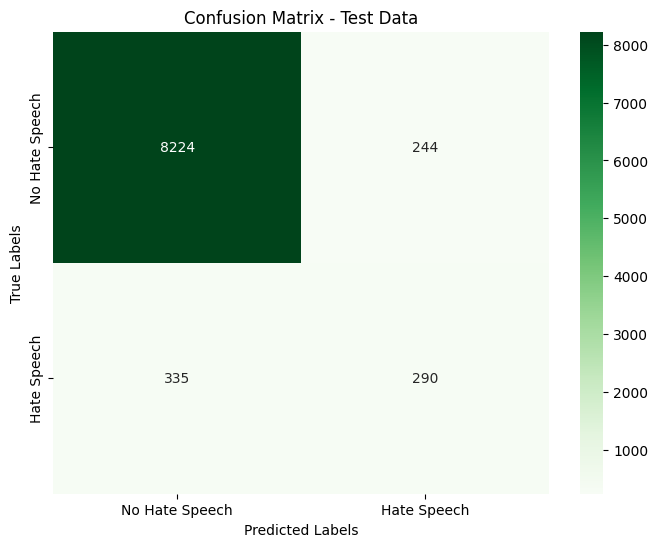

In [30]:
X_train_onehot,X_val_onehot,y_train_onehot,y_val_onehot, X_test_onehot, y_test_onehot = one_hot_and_split_data(X_train_data, y_train_data, X_test_data, y_test_data)
model, history = train_gru(X_train_onehot, y_train_onehot, X_val_onehot, y_val_onehot, 5000, len(X_train_onehot[0]), None, embedding_dim=200, epochs=10, batch_size=32)
evaluate_on_val(model, history, X_val_onehot, y_val_onehot)
evaluate_on_test(model, X_test_onehot, y_test_onehot)

##### Tokenize

In [50]:
X_resampled, y_resampled = random_over_sample(X_train_data, y_train_data)
X_train_token,X_val_token,y_train_token,y_val_token, X_test_token, y_test_token, tokenizer = tokenize_and_split_data(X_resampled, y_resampled, X_test_data, y_test_data)
glove_embedding_matrix = load_embeddings('drive/MyDrive/Colab Notebooks/data/embeddings/glove.twitter.27B.200d.txt', 200, tokenizer.word_index)

Epoch 1/20
948/948 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - Recall: 0.7431 - accuracy: 0.7006 - loss: 0.5074 - val_Recall: 0.9411 - val_accuracy: 0.9030 - val_loss: 0.2489
Epoch 2/20
948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - Recall: 0.9103 - accuracy: 0.8824 - loss: 0.2686 - val_Recall: 0.9886 - val_accuracy: 0.9342 - val_loss: 0.1737
Epoch 3/20
948/948 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - Recall: 0.9435 - accuracy: 0.9241 - loss: 0.1930 - val_Recall: 0.9960 - val_accuracy: 0.9583 - val_loss: 0.1210
Epoch 4/20
948/948 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - Recall: 0.9664 - accuracy: 0.9553 - loss: 0.1255 - val_Recall: 0.9995 - val_accuracy: 0.9772 - val_loss: 0.0726
Epoch 5/20
948/948 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - Recall: 0.9785 - accuracy: 0.9678 - loss: 0.0932 - val_Recall: 0.9995 - val_accuracy: 0.9818 - val_loss: 0.0616
Epoch 6/20
948/948 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - Recall: 0.9870 - accuracy: 0.9792 - loss: 0.0659 - val_Recall: 1.0000 - val_accuracy: 0.9761 - val_loss: 0.0728
E

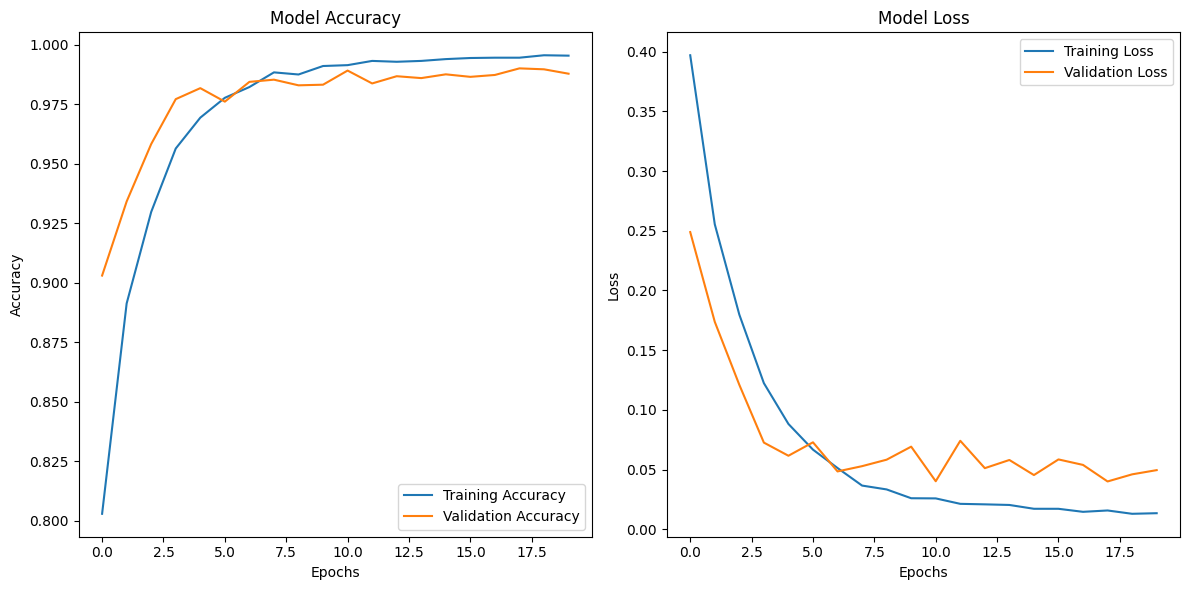


Validation Performance:
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.9859
Precision: 0.9725
Recall: 1.0000
F1 Score: 0.9861

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      3795
           1       0.97      1.00      0.99      3785

    accuracy                           0.99      7580
   macro avg       0.99      0.99      0.99      7580
weighted avg       0.99      0.99      0.99      7580



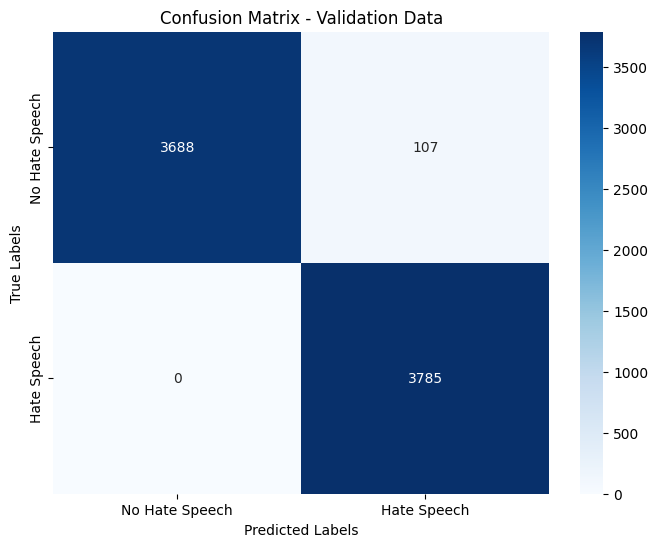


Test Performance:
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9507
Precision: 0.6266
Recall: 0.7008
F1 Score: 0.6616

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      8468
           1       0.63      0.70      0.66       625

    accuracy                           0.95      9093
   macro avg       0.80      0.83      0.82      9093
weighted avg       0.95      0.95      0.95      9093



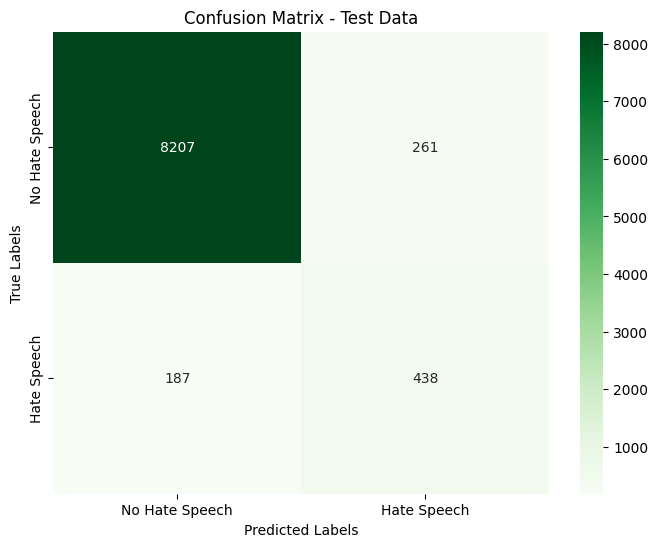

In [46]:
model, history = train_gru(X_train_token, y_train_token, X_val_token, y_val_token, len(tokenizer.word_index)+1, 40, glove_embedding_matrix, embedding_dim=200, epochs=20, batch_size=32)
evaluate_on_val(model, history, X_val_token, y_val_token)
evaluate_on_test(model, X_test_token, y_test_token)

## Modelloptimierung durch neuen Datensatz + Sampling

In [48]:
new_train_cleaned_data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/new_train_cleaned_rnn.csv")
new_test_cleaned_data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/new_test_cleaned_rnn.csv")

combined_train_data = pd.concat([train_cleaned_data, new_train_cleaned_data])
combined_test_data = pd.concat([test_cleaned_data, new_test_cleaned_data])

X_combined_train_data = combined_train_data['tweet_cleaned']
y_combined_train_data = combined_train_data['label']

X_combined_test_data = combined_test_data['tweet_cleaned']
y_combined_test_data = combined_test_data['label']


Epoch 1/20
3427/3427 ━━━━━━━━━━━━━━━━━━━━ 54s 15ms/step - Recall: 0.4646 - accuracy: 0.5486 - loss: 0.6650 - val_Recall: 0.8479 - val_accuracy: 0.8262 - val_loss: 0.3918
Epoch 2/20
3427/3427 ━━━━━━━━━━━━━━━━━━━━ 80s 15ms/step - Recall: 0.8855 - accuracy: 0.8682 - loss: 0.3135 - val_Recall: 0.9135 - val_accuracy: 0.8915 - val_loss: 0.2662
Epoch 3/20
3427/3427 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - Recall: 0.9451 - accuracy: 0.9353 - loss: 0.1643 - val_Recall: 0.9442 - val_accuracy: 0.9208 - val_loss: 0.2137
Epoch 4/20
3427/3427 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - Recall: 0.9728 - accuracy: 0.9669 - loss: 0.0898 - val_Recall: 0.9586 - val_accuracy: 0.9316 - val_loss: 0.1994
Epoch 5/20
3427/3427 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - Recall: 0.9829 - accuracy: 0.9780 - loss: 0.0605 - val_Recall: 0.9711 - val_accuracy: 0.9413 - val_loss: 0.1955
Epoch 6/20
3427/3427 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - Recall: 0.9877 - accuracy: 0.9840 - loss: 0.0438 - val_Recall: 0.9792 - val_accuracy: 0.9399

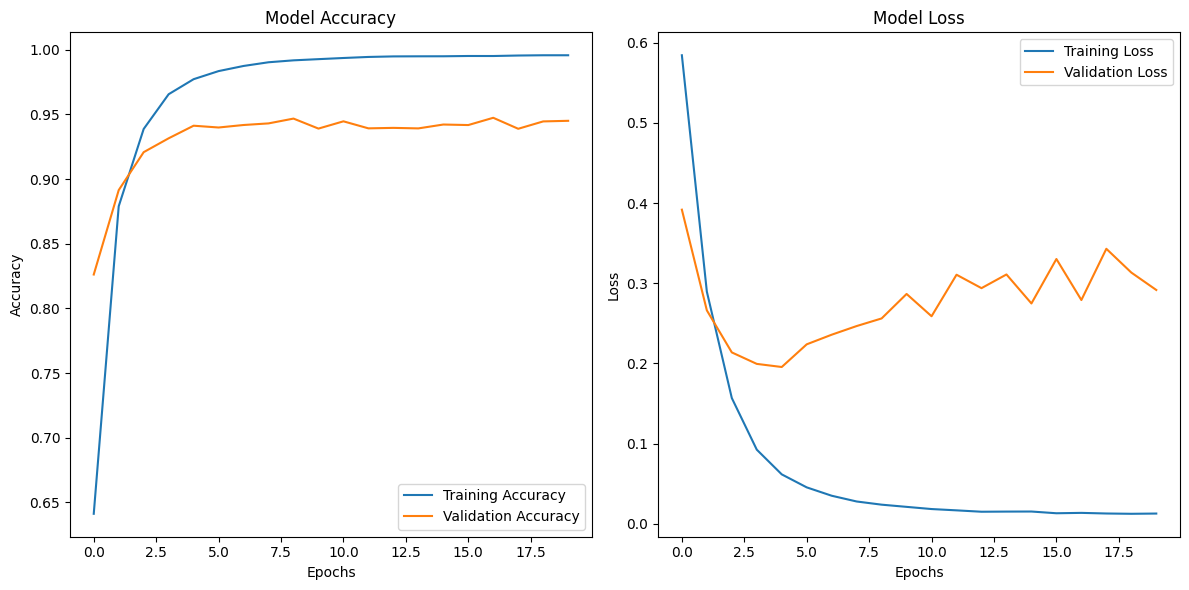


Validation Performance:
857/857 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.9404
Precision: 0.9033
Recall: 0.9851
F1 Score: 0.9425

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     13830
           1       0.90      0.99      0.94     13583

    accuracy                           0.94     27413
   macro avg       0.94      0.94      0.94     27413
weighted avg       0.94      0.94      0.94     27413



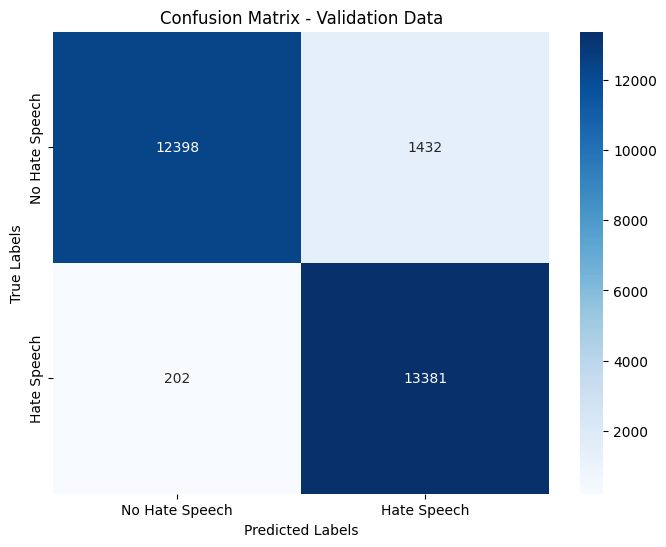


Test Performance:
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Accuracy: 0.8082
Precision: 0.6367
Recall: 0.6246
F1 Score: 0.6306

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     45754
           1       0.64      0.62      0.63     16256

    accuracy                           0.81     62010
   macro avg       0.75      0.75      0.75     62010
weighted avg       0.81      0.81      0.81     62010



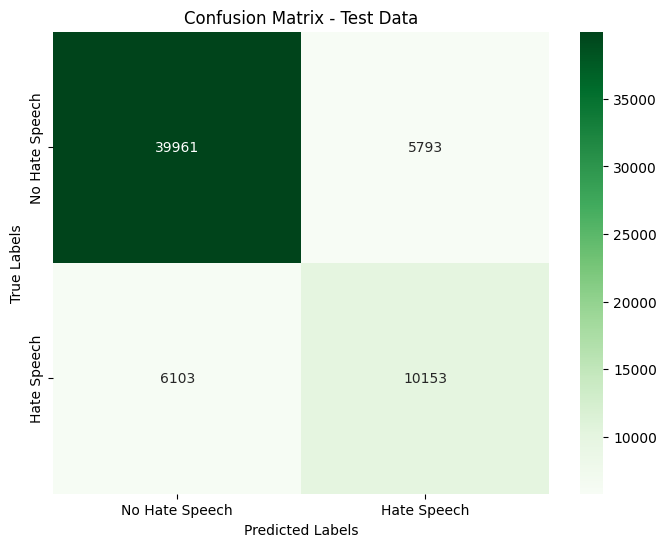

In [49]:
X_resampled, y_resampled = random_over_sample(X_combined_train_data, y_combined_train_data)
X_train_token,X_val_token,y_train_token,y_val_token, X_test_token, y_test_token, tokenizer = tokenize_and_split_data(X_resampled, y_resampled, X_combined_test_data, y_combined_test_data)
glove_embedding_matrix = load_embeddings('drive/MyDrive/Colab Notebooks/data/embeddings/glove.twitter.27B.200d.txt', 200, tokenizer.word_index)
model, history = train_gru(X_train_token, y_train_token, X_val_token, y_val_token, len(tokenizer.word_index)+1, 40, None, embedding_dim=200, epochs=20, batch_size=32)
evaluate_on_val(model, history, X_val_token, y_val_token)
evaluate_on_test(model, X_test_token, y_test_token)